Objective: 
Get list of relevant weather stations in Canada

In [336]:
# Imports
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame, plotting
from shapely.geometry import Point, Polygon, box, LineString
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
import random

In [3]:
# Read in data
stations = pd.read_csv('../Data/Weather/station_inventory.csv')

In [4]:
# Check data is read in
stations.head()

,Name,Province,Climate ID,Station ID,WMO ID,TC ID,Latitude (Decimal Degrees),Longitude (Decimal Degrees),Latitude,Longitude,Elevation (m),First Year,Last Year,HLY First Year,HLY Last Year,DLY First Year,DLY Last Year,MLY First Year,MLY Last Year
0,ACTIVE PASS,BRITISH COLUMBIA,1010066,14,NaN,NaN,48.87,-123.28,485200000,-1231700000,4.0,1984,1996,NaN,NaN,1984.0,1996.0,1984.0,1996.0
1,ALBERT HEAD,BRITISH COLUMBIA,1010235,15,NaN,NaN,48.40,-123.48,482400000,-1232900000,17.0,1971,1995,NaN,NaN,1971.0,1995.0,1971.0,1995.0
2,BAMBERTON OCEAN CEMENT,BRITISH COLUMBIA,1010595,16,NaN,NaN,48.58,-123.52,483500000,-1233100000,85.3,1961,1980,NaN,NaN,1961.0,1980.0,1961.0,1980.0
3,BEAR CREEK,BRITISH COLUMBIA,1010720,17,NaN,NaN,48.50,-124.00,483000000,-1240000000,350.5,1910,1971,NaN,NaN,1910.0,1971.0,1910.0,1971.0
4,BEAVER LAKE,BRITISH COLUMBIA,1010774,18,NaN,NaN,48.50,-123.35,483000000,-1232100000,61.0,1894,1952,NaN,NaN,1894.0,1952.0,1894.0,1952.0


In [5]:
# Check the column names
list(stations)

['Name',
 'Province',
 'Climate ID',
 'Station ID',
 'WMO ID',
 'TC ID',
 'Latitude (Decimal Degrees)',
 'Longitude (Decimal Degrees)',
 'Latitude',
 'Longitude',
 'Elevation (m)',
 'First Year',
 'Last Year',
 'HLY First Year',
 'HLY Last Year',
 'DLY First Year',
 'DLY Last Year',
 'MLY First Year',
 'MLY Last Year']

In [6]:
# Drop irrelevant columns
stations.drop([
 'WMO ID',
 'TC ID',
 #'Latitude (Decimal Degrees)',
 #'Longitude (Decimal Degrees)',
 'HLY First Year',
 'HLY Last Year',
 'DLY First Year',
 'DLY Last Year',
 'MLY First Year',
 'MLY Last Year'
], axis=1, inplace=True)

In [7]:
# Total number of stations
print('Total stations: '+str(len(stations.index)))

Total stations: 8762


In [8]:
# Keep only stations which are current
current = stations['Last Year'] == 2019
print('Total current stations: '+str(len(stations[current])))

active_for_last_20 = stations['First Year'] < 2000
print('Total stations active before 2000: '+str(len(stations[active_for_last_20])))

st = stations[current & active_for_last_20]
print('Total current stations active for last 20 yrs: '+str(len(st)))

Total current stations: 1514
Total stations active before 2000: 7629
Total current stations active for last 20 yrs: 720


In [51]:
# Set up geometry
geometry = [Point(xy)
             for xy in  zip(
                 st['Longitude (Decimal Degrees)'],
                 st['Latitude (Decimal Degrees)']
             )
            ]
gdf = GeoDataFrame(st, geometry=geometry)

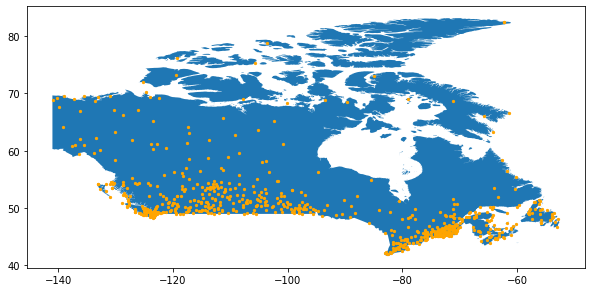

In [58]:
# Plot GeoDataFrame to Canada
world = gpd.read_file('../Data/World_Shapefile')
canada = world[world['SOVEREIGNT'] == 'Canada']
gdf.plot(
    ax=canada.plot(figsize=(10,10)), 
    marker='o', 
    color='orange', 
    markersize=5);

In [11]:
st.to_csv('../Data/Weather/current_station_inventory.csv')

Map current station to given coordinate system

In [276]:
# Read in grid data
grid = pd.read_csv('../Data/alberta_grid_system.csv')

In [277]:
# Check data is read in
grid.head()

,KEY,LATITUDE,LONGITUDE
0,49.0|-113.8,49.0,-113.8
1,49.0|-113.6,49.0,-113.6
2,49.0|-113.0,49.0,-113.0
3,49.0|-112.6,49.0,-112.6
4,49.0|-112.4,49.0,-112.4


In [278]:
from math import cos, asin, sqrt

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

def closest(weather_stations, grid_location):
    st_dict = weather_stations.to_dict('records')
    closest_station = min(st_dict, key=lambda s: distance(
        grid_location['LATITUDE']+0.1,
        grid_location['LONGITUDE']+0.1,
        s['Latitude (Decimal Degrees)'],
        s['Longitude (Decimal Degrees)']))
    
    grid_location['STATION ID'] = closest_station['Station ID']
    grid_location['STATION LATITUDE'] = closest_station['Latitude (Decimal Degrees)']
    grid_location['STATION LONGITUDE'] = closest_station['Longitude (Decimal Degrees)']

    return grid_location

In [279]:
# Go through grid
# For each grid location find closest weather station
# Append weather station to that grid location
grid = grid.apply(lambda row: closest(st, row), axis=1)

In [280]:
# Check that station ID column exists
grid.head()

,KEY,LATITUDE,LONGITUDE,STATION ID,STATION LATITUDE,STATION LONGITUDE
0,49.0|-113.8,49.0,-113.8,26850,49.13,-113.81
1,49.0|-113.6,49.0,-113.6,26971,49.20,-113.29
2,49.0|-113.0,49.0,-113.0,32256,49.05,-112.82
3,49.0|-112.6,49.0,-112.6,32256,49.05,-112.82
4,49.0|-112.4,49.0,-112.4,8804,49.13,-112.05


In [315]:
# Set up grid geometry
def set_shape(row):
    x = row.LONGITUDE
    y = row.LATITUDE 
    x2 = row['STATION LONGITUDE']
    y2 = row['STATION LATITUDE']
    
    row['box'] = box(x,y,x+0.2, y+0.2) 
    row['line'] = LineString([(x+0.1,y+0.1), (x2,y2)])
    row['point'] = Point((x2,y2))
    
    return row
    
grid_with_shapes = grid.apply(lambda row: set_shape(row), axis=1)
point_gdf = GeoDataFrame(grid.copy(), geometry=grid_with_shapes['point'])
box_gdf = GeoDataFrame(grid.copy(), geometry=grid_with_shapes['box'])
line_gdf = GeoDataFrame(grid.copy(), geometry=grid_with_shapes['line'])

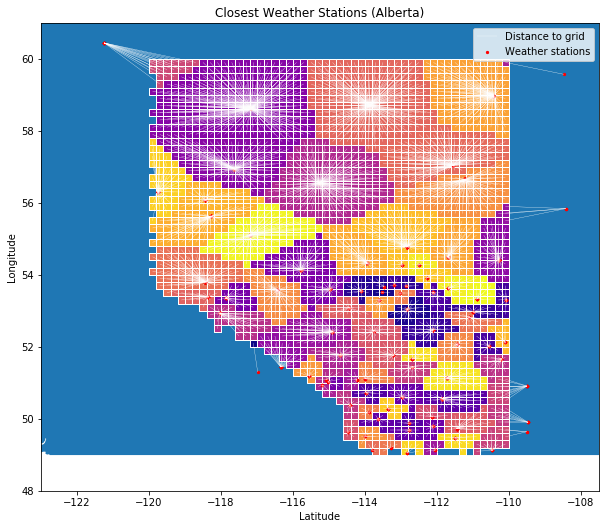

In [354]:
# Plot Canada, zoom in on Alberta
base = canada.plot(figsize=(10,10))
base.set_xlim(-123, -107.5) 
base.set_ylim(48, 61)

# Plot grid colors based on station ID
colors = plt.cm.plasma(np.linspace(0,1,box_gdf['STATION ID'].nunique()))
color = iter(colors)
for name, group in box_gdf.groupby('STATION ID'):
    base = group.plot(ax=base, edgecolor='white', color=next(color))

# Plot lines from each grid to closest weather station
base = line_gdf.plot(
    ax=base, 
    color='white',
    linewidth=0.3,
    label='Distance to grid')

# Plot weather station points
base = point_gdf.plot(
    ax=base,  
    color='red', 
    markersize=5,
    label='Weather stations');

base.set_xlabel('Latitude')
base.set_ylabel('Longitude')
base.set_title('Closest Weather Stations (Alberta)')
base.legend()


In [357]:
grid = grid[['KEY','STATION ID']]
grid.head()

,KEY,STATION ID
0,49.0|-113.8,26850
1,49.0|-113.6,26971
2,49.0|-113.0,32256
3,49.0|-112.6,32256
4,49.0|-112.4,8804


In [358]:
grid.to_csv('../Data/alberta_grid_system_with_station.csv')